# Trabalho Prático I - Classificação de Exoplanetas

- Disciplina: Aprendizado de Máquinas
- Aluno: Vítor Gabriel Reis Caitité
- Matrícula: 2021712430

## Objetivo:

O objetivo deste trabalho é praticar os conceitos aprendidos na disciplina Aprendizado de Máquinas e de adquirir experiência no uso de alguns dos principais métodos de classificação, na avaliação de modelos e na interpretação e apresentação de resultados de experimentos. Para isso, serão utilizados e comparados métodos de classificação baseados em princı́pios diferentes em um problema de classificação binária de candidatos a exoplanetas.

A tarefa é então classificar os objetos entre exoplanetas confirmados e falsos positivos. Cada observação corresponde a um objeto e as features são caracterı́sticas estimadas de cada possível exoplaneta, como tamanho, temperatura, features da estrela hospedeira, etc.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
import seaborn as sns
import tabulate

## Leitura e pré-processamento dos dados 

O tema abordado aqui é um problema de classificação binária de candidatos a exoplanetas
encontrados pela sonda espacial Kepler da NASA. Os dados foram obtidos do NASA Exoplanet Archive (https://exoplanetarchive.ipac.caltech.edu/).

Um exoplaneta é um planeta fora do sistema solar. A sonda primeiro identifica sinais de possı́veis exoplanetas, chamados de Kepler Object of Interest (KOI). Porém nem todos os KOIs são de fato exoplanetas, alguns são na verdade falsos positivos de origens diversas. 

A primeira coluna "Koi_name" tem funcionalidade única de identificar o KOI (e por isso não será utilizada como *feature* do problema). Já a coluna "Koi_disposition" traz a classificação correta (FALSE POSITIVE ou CONFIRMED) de cada KOI. As demais colunas são
features sobre o KOI extraı́das de diversas formas.

In [2]:
df = pd.read_csv('koi_data.csv')
df.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [3]:
X = df.drop(["kepoi_name", "koi_disposition"], axis='columns').to_numpy()
y = df["koi_disposition"].to_numpy()
y[y == "CONFIRMED"] = 1
y[y == "FALSE POSITIVE"] = 0
y = np.array(y.tolist())

## Desenvolvimento de rotinas para avaliação de cada modelo

As funções abaixo são respectivamente para as seguintes funcionalidades:
  - Plot da curva ROC
  - Plot da matriz de confusão 
  - Aplicação da validação cruzada (com 5 folds)

In [4]:
def plot_roc_curve(tprs):
    plt.figure(figsize=(6,4))
    base_fpr = np.linspace(0, 1, 101)
    for tpr in tprs:
        plt.plot(base_fpr, tpr, 'b', alpha=0.15)
    # Mean and Std 
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    # Plot mean ROC curve and also the variance around it to build confidence intervals
    plt.plot(base_fpr, mean_tprs, 'b')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("ROC Curve")
    plt.show()

In [5]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):
    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    plt.figure(figsize=(7,4))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="BuPu", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

In [6]:
def apply_cross_validation(model, params={}):
    k_fold = KFold(n_splits=5, shuffle=True, random_state=1)
    predicted_classes = []
    pred_proba = []
    real_classes = []
    accuracy = np.zeros(5)
    precision = np.zeros(5)
    recall = np.zeros(5)
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    idx = 0
    for train_indices, test_indices in k_fold.split(X, y):
        normalizer = MinMaxScaler()
        X_train = normalizer.fit_transform(X[train_indices])
        X_test = normalizer.transform(X[test_indices])
        y_train = y[train_indices]
        y_test = y[test_indices]

        clf = model(**params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        predicted_classes = np.append(predicted_classes, y_pred)
        real_classes = np.append(real_classes, y_test)
        #calculating accuracy, precision and reall
        precision[idx] = precision_score(y_test, y_pred)
        recall[idx] = recall_score(y_test, y_pred)
        accuracy[idx] = accuracy_score(y_test, y_pred)
        y_score = clf.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        pred_proba = np.append(pred_proba, y_score[:, 1])
        idx +=1
        print(f'Accuracy (fold {idx}): ' + '{:.4f}'.format(accuracy_score(y_test, y_pred)))  
    mean_accuracy = '{:.4f}'.format(accuracy.mean()) + "+/-" + '{:.4f}'.format(accuracy.std())
    mean_precision ='{:.4f}'.format(precision.mean()) + "+/-" + '{:.4f}'.format(precision.std())
    mean_recall = '{:.4f}'.format(recall.mean()) + "+/-" + '{:.4f}'.format(recall.std())
    print(f"\nMean Accuracy: " + mean_accuracy) 
    print(f"Mean Precision: " + mean_precision) 
    print(f"Mean Recall: " + mean_recall) 
    plot_confusion_matrix(real_classes, predicted_classes, [0, 1])
    plot_roc_curve(np.array(tprs))
    pr_curve = precision_recall_curve(real_classes, pred_proba)
    return clf, mean_accuracy, mean_precision, mean_recall, np.array(tprs), pr_curve

## Naive Bayes

A regra de decisão de Bayes estabelece que o vetor **x** seja atribuido à classe $C_i$ de maior probabilidade posterior $P(C_i|$**x**$)$. Sendo $P(C_i|$**x**$)$ = $\frac{P(\textbf{x}|C_i)P(C_i)}{P(\textbf{x})}$.

Para um problema de classificação binário a regra de classificação pode ser expressa da seguinte forma:

$Classe(x) = 
    \begin{cases}
      C_1 & \text{if $\frac{P(x|C_1)}{P(x|C_2)} \ > \ k$}\\
      C_2 & \text{otherwise}
    \end{cases}       $

onde $k=\frac{P(C_2)}{P(C_1)}$.

Generalizando, para problemas com 2 classes ou mais, basta atribuir a **x** a classe que resultar no maior valor da expressão $P(\textbf{x}|C_i)P(C_i)$.

O classificador Naive Bayes  assume que as features de **x** são independentes entre si. Em outras palavras um classificador Naive Bayes assume que a presença de uma característica particular em uma classe não está relacionada com a presença de qualquer outro recurso. 

Accuracy (fold 1): 0.9193
Accuracy (fold 2): 0.9049
Accuracy (fold 3): 0.9221
Accuracy (fold 4): 0.9183
Accuracy (fold 5): 0.9231

Mean Accuracy: 0.9175+/-0.0066
Mean Precision: 0.8459+/-0.0132
Mean Recall: 0.9727+/-0.0070


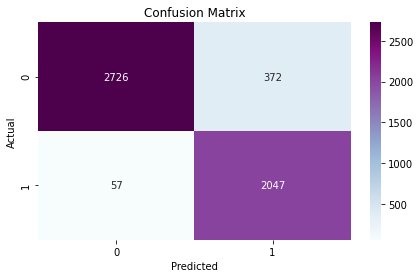

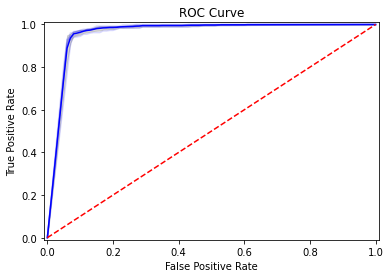

In [7]:
model = GaussianNB
clf, mean_accuracy_nb, mean_precision_nb, mean_recall_nb, roc_nb, pr_nb = apply_cross_validation(model)

Como pode ser visto acima as métricas utilizadas para avaliação do modelo foram:
  - $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$
  - $Precision = \frac{TP}{TP + FP}$
  - $Recall = \frac{TP}{TP + FN}$
 
sendo:
  - True Positive (TP):  A classe positiva real é prevista como positiva.
  - True Negative (TN):  A classe negativa real é prevista negativa.
  - False Positive (FP): A classe real é negativa, mas prevista como positiva. 
  - False Negative (FN): A classe real é positiva, mas prevista como negativa.
  
Bacicamente, acurácia é simplesmente uma proporção das observações corretamente previstas para o total de observações. Precisão é a razão de observações positivas previstas corretamente para o total de observações positivas previstas. E Recall é a proporção de observações positivas corretamente previstas para todas as observações positivas. Em todas essas métricas, quanto mais próximo de 1 (ou 100%, considerando resultados percentuais), melhor o resultado.

Como pode ser notado acima, para o modelo Naive Bayes, utilizado como baseline, os resultados médios obtidos da execução de um 5-fold cross-validation foram:

 - Mean Accuracy: 0.9175+/-0.0066
 - Mean Precision: 0.8459+/-0.0132
 - Mean Recall: 0.9727+/-0.0070

Além disso, foram plotados a matriz de confusão e a curva ROC obtidas. A matriz de confusão é basicamente uma tabela que permite a visualização do desempenho de um algoritmo, tipicamente de aprendizado supervisionado. Cada linha da matriz representa as instâncias de uma classe real enquanto cada coluna representa as instâncias de uma classe prevista. Quanto maior os valores na diagonal principal e menor os outros valores, melhor será o desempenho do modelo (isso pode ser observado na matriz de confusão acima). Já a curva ROC é criada plotando a taxa de verdadeiros positivos (TPR) em relação à taxa de falsos positivos (FPR) em diferentes limiares de classificação. Uma maneira de se analisar a curva ROC é através da área abaixo da curva, quanto maior ela for, melhor é o resultado.

## Decision Tree

Uma árvore de decisão é um mapa dos possíveis resultados de uma série de escolhas relacionadas. Uma árvore de decisão normalmente começa com um único nó, que se ramifica em possíveis resultados. Cada um desses resultados leva a nós adicionais, que se ramificam em outras possibilidades.

Algoritmos para construção de árvores de decisão geralmente funcionam de cima para baixo, escolhendo uma variável em cada etapa que melhor divide o conjunto de itens. Existem diferentes métricas para avaliar a qualidade da divisão, duas muito comuns são o ganho de informação e o indíce de Gini (utilizado pelo algoritmo abaixo).

O primeiro teste será a realização de um *grid search* variando o comprimento máximo da árvore entre 1 e 10, e também com comprimento ilimitado. Variar esse parâmetro resulta em modelos com capacidades diferentes: árvores maiores têm mais complexidade do que árvores pequenas, o que é bom para reduzir o erro de treinamento. No entanto, pode levar o modelo a overfitting, o que não queremos, pois, piorará a generalização do modelo. Abaixo é possível observar o resultado obtido com a realização do *grid search*.

In [8]:
lst = list(range(1,11))
lst.append(None)
# Grid Search application
grid_params_DecisionTree = [{'DecisionTreeClassifier__max_depth': lst}]
pipe_tree = Pipeline([('scaler',  MinMaxScaler()),
            ('DecisionTreeClassifier', DecisionTreeClassifier())])
clf = GridSearchCV(pipe_tree, grid_params_DecisionTree , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('DecisionTreeClassifier',
                                        DecisionTreeClassifier())]),
             param_grid=[{'DecisionTreeClassifier__max_depth': [1, 2, 3, 4, 5,
                                                                6, 7, 8, 9, 10,
                                                                None]}],
             scoring='accuracy', verbose=1)

In [9]:
max_depth = clf.best_params_['DecisionTreeClassifier__max_depth']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for max_depth = " + str(max_depth) )

The best mean accuracy was 0.9473 and was achieved for max_depth = 6


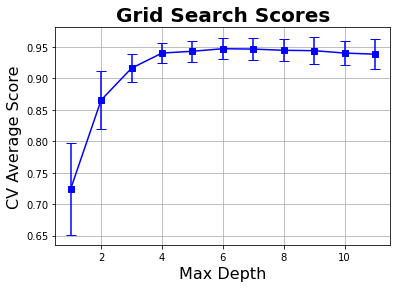

In [10]:
def plot_grid_search(cv_results, grid_param_1, name_param_1):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean)
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd)

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)
    ax.errorbar(grid_param_1, scores_mean, scores_sd, color = 'blue', marker='s', capsize=5)

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')
    
# Calling Method 
lst = list(range(1,12))
plot_grid_search(clf.cv_results_, lst, 'Max Depth')

Abaixo está a aplicação da arvore de decisão com a melhor altura máxima definida acima. 
É notável pelos resultados abaixo que esse modelo obteve melhores resultados de acurácia e precisão do que o Naive Bayes, contudo esse último ganha no quesito recall. Isso mostra que apesar de a árvore de decisão resultar em um classificador que acerta uma proporção maior de classificações, o Naive Bayes foi melhor em classificar amostras da classe positiva. Isso pode ser facilmente observado ao se olhar para as matrizes de confusão dos 2 modelos. 

Accuracy (fold 1): 0.9491
Accuracy (fold 2): 0.9462
Accuracy (fold 3): 0.9462
Accuracy (fold 4): 0.9577
Accuracy (fold 5): 0.9538

Mean Accuracy: 0.9506+/-0.0045
Mean Precision: 0.9221+/-0.0096
Mean Recall: 0.9586+/-0.0067


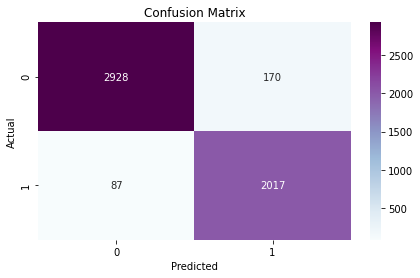

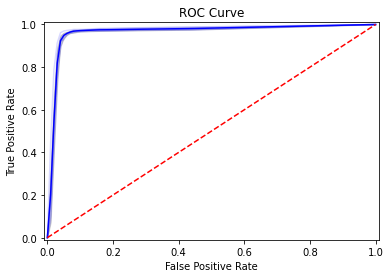

In [11]:
model = DecisionTreeClassifier
params = {'max_depth' : max_depth}
clf, mean_accuracy_dt, mean_precision_dt, mean_recall_dt, roc_dt, pr_dt = apply_cross_validation(model, params)

Abaixo está mostrada a árvore de decisão selecionada nos testes acima. Nessa figura é possível observar quais foram os critérios criados para divisão dos dados, o valor do índice Gini encontrado e também o altura da árvore selecionada pelo *grid search* acima.

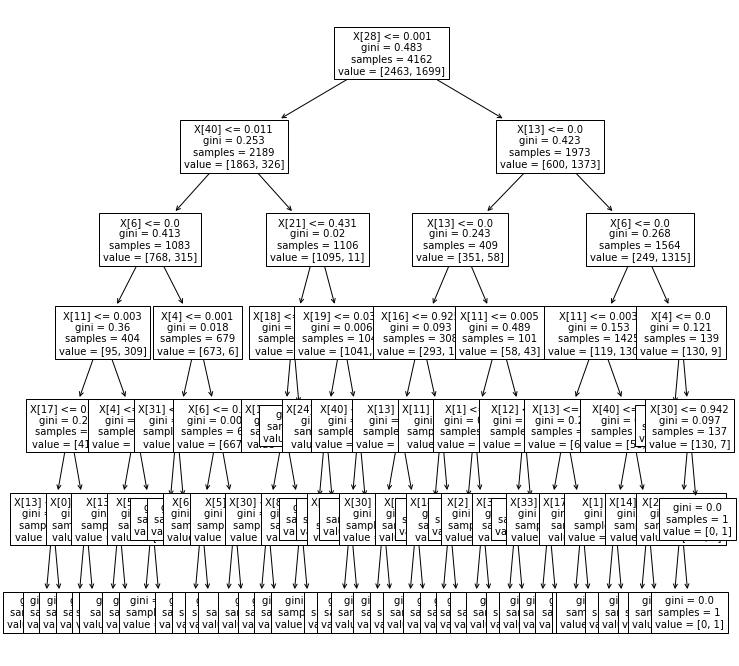

In [12]:
# plot tree
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(clf, fontsize=10)
plt.show()

## SVM

Máquina de Vetores Suporte (SVM) é um algoritmo formulado como um problema de otimização quadrática, que visa encontrar um hiperplano separador que maximiza sua distância até os dados de diferentes classes.

Uma importante técnica aplicada por modelos SVM é utilização do truque do kernel. A função Kernel nos permite operar no espaço original, sem precisar computar as coordenadas dos dados em um espaço dimensional superior. A intenção é mapear os pontos para um espaço de recurso dimensional mais alto de maneira que esses dados se tornem linearmente separáveis no espaço de recursos.

Abaixo foram utilizados diferentes modelos SVM com diferentes kernels: linear, sigmoid, polinomial e RBF. Cada kernel resulta em diferentes representações dos dados.

Para cada SVM abaixo, a seguinte metodologia de teste foi seguida:

  - 1. Aplicação de um grid search para encontrar os valores "ideais" dos parâmetros C e gamma.  O parâmetro C pode ser visto como uma penalização imposta ao modelo durante o treinamento para cada amostra erroneamente classificada. Assim, um alto valor de C resulta em classificador que busca a separação completa entre classes (podendo inclusive gerar overfitting ao resultar em fronteiras de separação muito complexas). Em contrapartida, baixos valores de C flexibilizam a etapa de treinamento e permitem fronteiras de decisão com alguns erros (também chamado de Soft Margin). Isso pode ajudar na generalização do modelo mas também pode levar à underfitting. Nesta etapa serão testados 50 valores de C entre 0 e 100. Já o parâmetro gamma ($\gamma$) se trata de um coeficiente para os kernels RBF, polinomial e sigmóide. Nesta etapa serão testados $\gamma = \frac{1}{n_{features}}$ ('auto') e $\gamma = \frac{1}{(n_{features} \cdot var(X))}$ ('scale'). 
 
  - 2. Teste da SVM com os melhores parâmetros definidos em 1. Aqui, para cada SVM, serão avaliadas as métricas acurácia, precisão e *recall*. Além disso, serão plotadas a matriz de confusão e curva ROC.
  

### SVM Kernel Linear

Fitting 5 folds for each of 50 candidates, totalling 250 fits
The best mean accuracy was 0.9441 and was achieved for C = 100.0


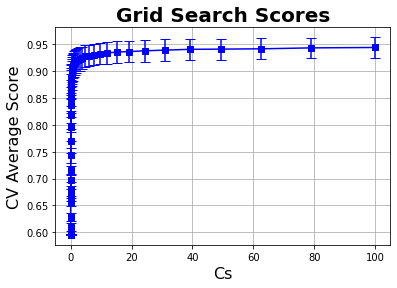

In [13]:
lst = np.logspace(-3, 2, 50)
# Grid Search application
grid_params_svm = [{'SVM__C': lst}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="linear"))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
#Results of Grid Seach:
C  = clf.best_params_['SVM__C']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) )
plot_grid_search(clf.cv_results_, lst, 'Cs')

Accuracy (fold 1): 0.9443
Accuracy (fold 2): 0.9472
Accuracy (fold 3): 0.9433
Accuracy (fold 4): 0.9442
Accuracy (fold 5): 0.9538

Mean Accuracy: 0.9466+/-0.0039
Mean Precision: 0.9124+/-0.0078
Mean Recall: 0.9602+/-0.0048


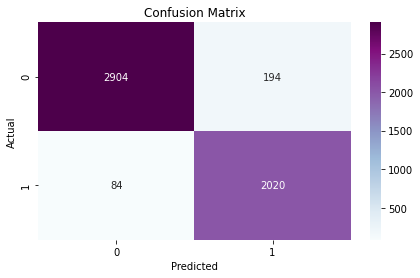

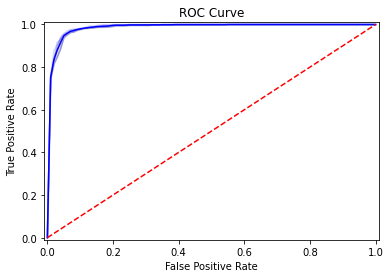

In [14]:
model = svm.SVC
params = {'kernel' : "linear", 'C' : C, 'probability' : True}
clf, mean_accuracy_linear_svm, mean_precision_linear_svm, mean_recall_linear_svm, roc_linear_svm, pr_lsvm = apply_cross_validation(model, params)

### SVM Kernel Sigmoid

In [15]:
def plot_grid_search_2_params(searcher, grid_param_1, grid_param_2, name_param_1, name_param_2):
    scores_mean = searcher.cv_results_['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1), len(grid_param_2)).T
    scores_sd = searcher.cv_results_['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_1), len(grid_param_2)).T
    print('Best params = {}'.format(searcher.best_params_))
    print('Best score = {}'.format(scores_mean.max()))
    _, ax = plt.subplots(1,1)
    
    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.errorbar(grid_param_1, scores_mean[idx, :], scores_sd, marker='s', capsize=5, label=name_param_2 + ': ' + str(val))
    
    ax.tick_params(axis='x')
    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')
    ax.legend(loc='best')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
The best mean accuracy was 0.9216 and was achieved for C = 100.0and gamma = auto
Best params = {'SVM__C': 100.0, 'SVM__gamma': 'auto'}
Best score = 0.9215759624621297


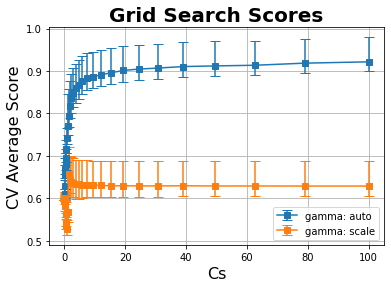

In [16]:
lst = np.logspace(-3, 2, 50)
# Grid Search application
grid_params_svm = [{'SVM__C': lst,
                   'SVM__gamma' : ['auto', 'scale']}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="sigmoid"))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
C  = clf.best_params_['SVM__C']
gamma = clf.best_params_['SVM__gamma']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) + "and gamma = " + str(gamma) )
plot_grid_search_2_params(clf, lst, ['auto', 'scale'], 'Cs', 'gamma')

No gráfico acima fica claro a importância dos parâmetros C e principalmente gamma. Um valor de gamma ruim não permitiu uma acurácia maior que 75% para nenhum dos valores de C testados. Enquanto que o valor de gamma melhor permitiu acurácias maiores de 90% para diversos valores de C entre 20 e 100.

Accuracy (fold 1): 0.9203
Accuracy (fold 2): 0.9241
Accuracy (fold 3): 0.9221
Accuracy (fold 4): 0.9250
Accuracy (fold 5): 0.9279

Mean Accuracy: 0.9239+/-0.0026
Mean Precision: 0.8745+/-0.0083
Mean Recall: 0.9478+/-0.0077


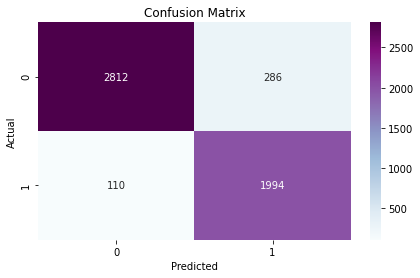

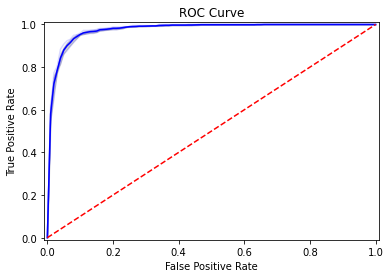

In [17]:
model = svm.SVC
params = {'kernel' : "sigmoid", 'gamma' : gamma, 'C' : C, 'probability' : True}
clf, mean_accuracy_sigmoid_svm, mean_precision_sigmoid_svm, mean_recall_sigmoid_svm, roc_sigmoid_svm, pr_ssvm= apply_cross_validation(model, params)

### SVM Kernel Polinomial

Fitting 5 folds for each of 100 candidates, totalling 500 fits
The best mean accuracy was 0.9454 and was achieved for C = 49.417133613238384and gamma = scale
Best params = {'SVM__C': 49.417133613238384, 'SVM__gamma': 'scale'}
Best score = 0.9454106628242075


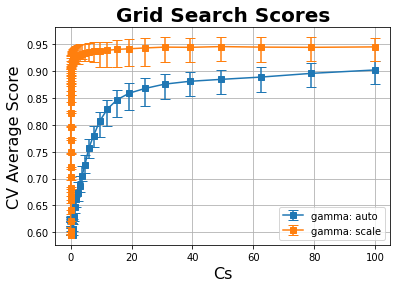

In [18]:
# The degree of the sigmoid kernel tested here was 3.
lst = np.logspace(-3, 2, 50)
# Grid Search application
grid_params_svm = [{'SVM__C': lst,
                   'SVM__gamma' : ['auto', 'scale']}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="poly", gamma='scale'))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
C  = clf.best_params_['SVM__C']
gamma = clf.best_params_['SVM__gamma']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) + "and gamma = " + str(gamma) )
plot_grid_search_2_params(clf, lst, ['auto', 'scale'], 'Cs', 'gamma')

Accuracy (fold 1): 0.9452
Accuracy (fold 2): 0.9491
Accuracy (fold 3): 0.9433
Accuracy (fold 4): 0.9490
Accuracy (fold 5): 0.9510

Mean Accuracy: 0.9475+/-0.0028
Mean Precision: 0.9144+/-0.0057
Mean Recall: 0.9601+/-0.0035


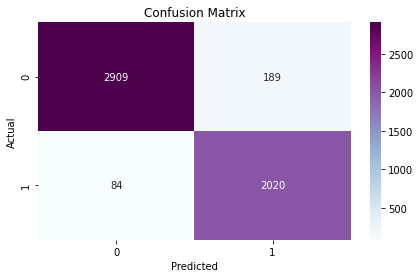

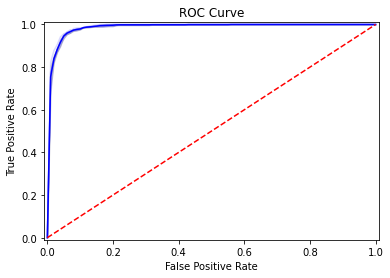

In [19]:
model = svm.SVC
params = {'kernel' : "poly", 'gamma' : gamma, 'C' : C, 'probability' : True}
clf, mean_accuracy_poly_svm, mean_precision_poly_svm, mean_recall_poly_svm, roc_poly_svm, pr_psvm = apply_cross_validation(model, params)

### SVM Kernel RBF

Fitting 5 folds for each of 100 candidates, totalling 500 fits
The best mean accuracy was 0.9371 and was achieved for C = 100.0and gamma = scale
Best params = {'SVM__C': 100.0, 'SVM__gamma': 'scale'}
Best score = 0.9371438335919604


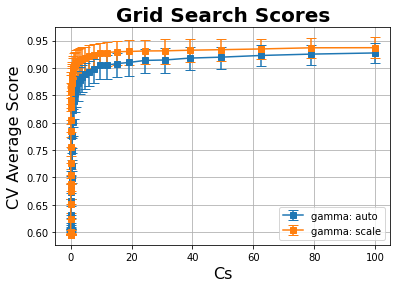

In [20]:
lst = np.logspace(-3, 2, 50)
# Grid Search application
grid_params_svm = [{'SVM__C': lst,
                   'SVM__gamma' : ['auto', 'scale']}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="rbf", gamma='scale'))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
C  = clf.best_params_['SVM__C']
gamma = clf.best_params_['SVM__gamma']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) + "and gamma = " + str(gamma) )
plot_grid_search_2_params(clf, lst, ['auto', 'scale'], 'Cs', 'gamma')

Accuracy (fold 1): 0.9414
Accuracy (fold 2): 0.9414
Accuracy (fold 3): 0.9365
Accuracy (fold 4): 0.9433
Accuracy (fold 5): 0.9481

Mean Accuracy: 0.9421+/-0.0037
Mean Precision: 0.9022+/-0.0095
Mean Recall: 0.9612+/-0.0039


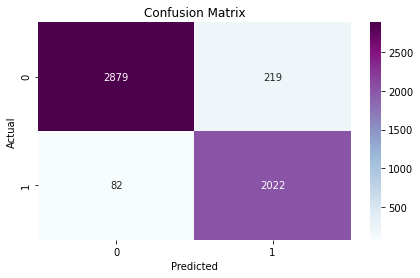

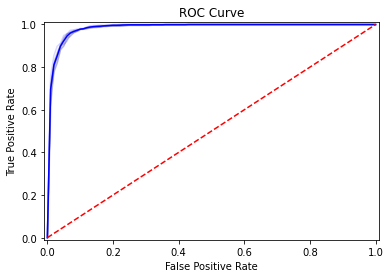

In [21]:
model = svm.SVC
params = {'kernel' : "rbf", 'gamma' : gamma, 'C': C, 'probability' : True}
clf, mean_accuracy_rbf_svm, mean_precision_rbf_svm, mean_recall_rbf_svm, roc_rbf_svm, pr_rsvm = apply_cross_validation(model, params)

### Comparação entre os modelos SVM

Na tabela abaixo é possível observar uma performance similar entre as SVMs de diferentes kernels. Note que o modelo com kernel polinomial atingiu melhores valores médios para acurácia e precisão. Além disso, considerando o desvio padrão como uma margem de erro o modelo possui um desempenho similar a SVM com kernels linear e RBF. Em todos os quesitos testados a SVM com kernel sigmoid se saiu pior.

In [22]:
data = [["SVM Kernel", 'Accuracy', 'Precision', 'Recall'],
        ["Linear", mean_accuracy_linear_svm, mean_precision_linear_svm, mean_recall_linear_svm],
        ["Sigmoid", mean_accuracy_sigmoid_svm, mean_precision_sigmoid_svm, mean_recall_sigmoid_svm],
        ["Poly", mean_accuracy_poly_svm, mean_precision_poly_svm, mean_recall_poly_svm],
        ["RBF", mean_accuracy_rbf_svm, mean_precision_rbf_svm, mean_recall_rbf_svm]]
table = tabulate.tabulate(data, tablefmt='grid')
print(table)

+------------+-----------------+-----------------+-----------------+
| SVM Kernel | Accuracy        | Precision       | Recall          |
+------------+-----------------+-----------------+-----------------+
| Linear     | 0.9466+/-0.0039 | 0.9124+/-0.0078 | 0.9602+/-0.0048 |
+------------+-----------------+-----------------+-----------------+
| Sigmoid    | 0.9239+/-0.0026 | 0.8745+/-0.0083 | 0.9478+/-0.0077 |
+------------+-----------------+-----------------+-----------------+
| Poly       | 0.9475+/-0.0028 | 0.9144+/-0.0057 | 0.9601+/-0.0035 |
+------------+-----------------+-----------------+-----------------+
| RBF        | 0.9421+/-0.0037 | 0.9022+/-0.0095 | 0.9612+/-0.0039 |
+------------+-----------------+-----------------+-----------------+


## k-NN

O algoritmo de k-vizinhos mais próximos (k-NN) é um algoritmo de aprendizado de máquina supervisionado simples de implementar que pode ser usado para resolver problemas de classificação e regressão. O algoritmo k-NN assume que coisas semelhantes existem nas proximidades. Em outras palavras, coisas semelhantes estão próximas umas das outras. A lógica de classificação do k-NN é muito simples, ele observa a classe dos vizinhos mais próximos (dos dados de treinamento), e realiza uma votação onde a classe da maioria determina a classe do novo ponto.

Resumidamente, o classificador recebe um dado novo (não classificado) e mede sua distância em relação a cada um dos dos dados de treinamento. Então, seleciona-se as k menores distâncias e verifica-se as classes desses k dados. Contabiliza-se a quantidade de vezes que cada classe que apareceu e atribui ao novo dado a classe da maioria.

Para um k é pequeno, a classificação fica mais sensível a regiões bastante próximas (o que pode gerar *overfitting*). Já um k grande demais pode gerar *underfitting*. Assim, é necessário achar um k "ideal", que seja grande o suficiente para deixar a classificação mais robusta (menos sujeita a ruídos) e pequeno o suficiente para não ocorrer *underfitting*. Nesse sentido foram testados abaixo 51 valores para k entre 1 e 101. O valor que resultou na maior acurácia média foi o valor escolhido para realização de mais análises.

Fitting 5 folds for each of 51 candidates, totalling 255 fits
The best mean accuracy was 0.8343 and was achieved for K = 13


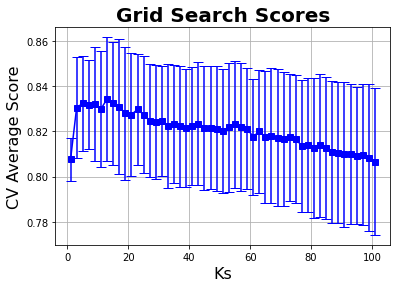

In [23]:
lst =  list(np.linspace(1, 101, 51, dtype=int))
# Grid Search application
grid_params_knn = [{'knn__n_neighbors': lst}]
pipe_knn = Pipeline([('scaler',  MinMaxScaler()),
            ('knn', KNeighborsClassifier())])
clf = GridSearchCV(pipe_knn, grid_params_knn , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
k  = clf.best_params_['knn__n_neighbors']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for K = " + str(k) )
plot_grid_search(clf.cv_results_, lst, 'Ks')

Accuracy (fold 1): 0.8415
Accuracy (fold 2): 0.8309
Accuracy (fold 3): 0.8462
Accuracy (fold 4): 0.8279
Accuracy (fold 5): 0.8183

Mean Accuracy: 0.8329+/-0.0099
Mean Precision: 0.7275+/-0.0224
Mean Recall: 0.9385+/-0.0163


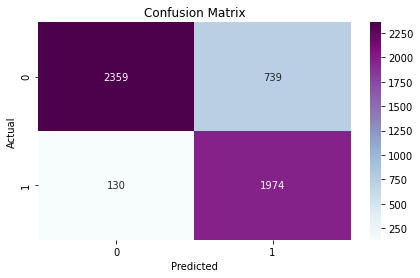

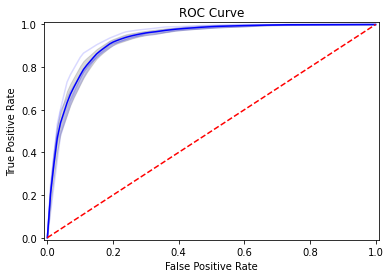

In [24]:
model = KNeighborsClassifier
params = {'n_neighbors' : k}
clf, mean_accuracy_knn, mean_precision_knn, mean_recall_knn, roc_knn, pr_knn = apply_cross_validation(model, params)

Dos modelos testados até então o k-NN foi o que resultou em um pior desempenho. O k-NN resultou em menores valores de acurácia, precisão e *recall* se comparado aos modelos anteriores. Esse desempenho pior pode também ser observado na matriz de confusão (que mostra uma quantidade significativa de **falsos positivos**). Além disso, é notável que a curva ROC do k-NN mostra um resultado pior se comparada com as curvas ROC dos outros modelos (essa comparação será mostrada no final deste *script*). 

## Random Forest

O Random Forest consiste em um grande número de árvores de decisão individuais que operam como um conjunto. Cada árvore individual no Random Forest gera uma previsão de classe e a classe com mais votos se torna a previsão do modelo. 

A ideia geral desse modelo é que um grande número de árvores relativamente não correlacionados operando como um comitê superará qualquer um dos modelos constituintes individuais.

Dois parâmetros importantes desse modelo são o tamanho de cada árvore e a quantidade de árvores. Para o primeiro parâmetro foi selecionado a mesma altura da árvore definida no teste do modelo "Decision Tree". Já o número de árvores foi selecionado por um *grid search*, como mostrado abaixo. 


Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best mean accuracy was 0.9608 and was achieved for n_estimators = 70


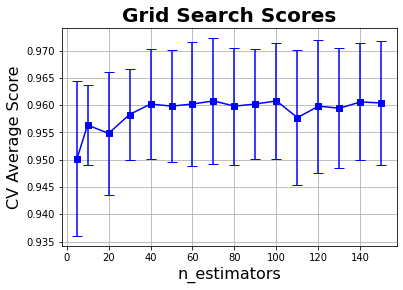

In [25]:
lst =  [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
# Grid Search application
# The max depth will be the value encountered in Decision Tree test
grid_params_random_forest = [{'RandomForest__n_estimators': lst}]
pipe_random_forest = Pipeline([('scaler',  MinMaxScaler()),
            ('RandomForest', RandomForestClassifier(max_depth = max_depth))])
clf = GridSearchCV(pipe_random_forest, grid_params_random_forest , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
n_estimators  = clf.best_params_['RandomForest__n_estimators']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for n_estimators = " + str(n_estimators) )
plot_grid_search(clf.cv_results_, lst, 'n_estimators')

Accuracy (fold 1): 0.9616
Accuracy (fold 2): 0.9616
Accuracy (fold 3): 0.9587
Accuracy (fold 4): 0.9692
Accuracy (fold 5): 0.9606

Mean Accuracy: 0.9623+/-0.0036
Mean Precision: 0.9445+/-0.0063
Mean Recall: 0.9632+/-0.0061


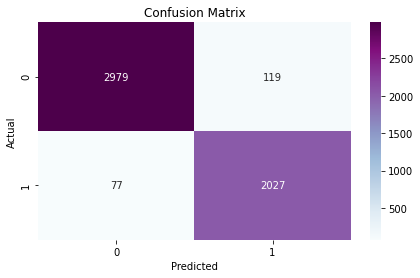

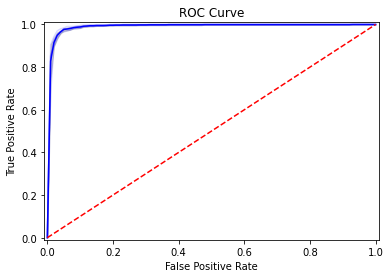

In [26]:
model = RandomForestClassifier
params = {'n_estimators' : n_estimators, "max_depth" : max_depth}
clf, mean_accuracy_rf, mean_precision_rf, mean_recall_rf, roc_rf, pr_rf = apply_cross_validation(model, params)

Dos modelos testados até aqui o *Random Forest* foi o que resultou no melhor resultado de acurácia. Além disso, esse modelo também resultou (até o momento) na melhor matriz de confusão (com maiores valores na diagonal principal) e na melhor curva ROC (com maior area sob a curva). 

## Gradient Tree Boosting

O *Gradient Boosting* é um algoritmo de aprendizado de máquina que utiliza uma combinação de resultados de preditores fracos, com o objetivo de produzir um melhor modelo preditivo. No caso do *Gradient Tree Boosting* é realizada uma combinação de árvores de decisão. Esse algoritmo constrói o modelo em etapas e os generaliza, permitindo a otimização de uma função de perda diferenciável arbitrária. 

A ideia desse algoritmo é gerar uma corrente de árvores de decisão, onde cada uma tem como objetivo minimizar o erro do modelo anterior, por meio da função de perda. Cada árvore é multiplicada um valor (*learning rate*). Esse valor, tem como objetivo determinar o impacto de cada árvore no modelo final. Quanto menor o valor, menor a contribuição de cada árvore.

Nos testes abaixo, o *learning rate* foi mantido em 0.1 e o número de estimadores foi selecionado através de um *grid search*. O tamanho de cada árvore foi mesmo escolhido para o *Random Forest*.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best mean accuracy was 0.9700 and was achieved for n_estimators = 150


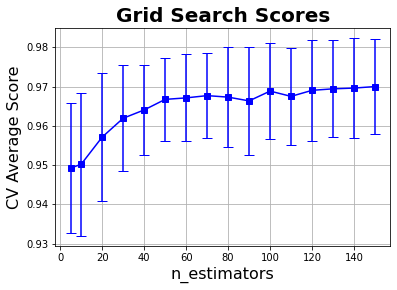

In [27]:
lst =  [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
# Grid Search application
# The max depth will be the value encountered in Decision Tree test
grid_params_gradient_boosting = [{'GradientBoosting__n_estimators': lst}]
pipe_gradient_boosting = Pipeline([('scaler',  MinMaxScaler()),
            ('GradientBoosting', GradientBoostingClassifier(max_depth = max_depth))])
clf = GridSearchCV(pipe_gradient_boosting, grid_params_gradient_boosting, scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
n_estimators  = clf.best_params_['GradientBoosting__n_estimators']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for n_estimators = " + str(n_estimators) )
plot_grid_search(clf.cv_results_, lst, 'n_estimators')

Accuracy (fold 1): 0.9750
Accuracy (fold 2): 0.9721
Accuracy (fold 3): 0.9712
Accuracy (fold 4): 0.9837
Accuracy (fold 5): 0.9760

Mean Accuracy: 0.9756+/-0.0044
Mean Precision: 0.9639+/-0.0076
Mean Recall: 0.9760+/-0.0103


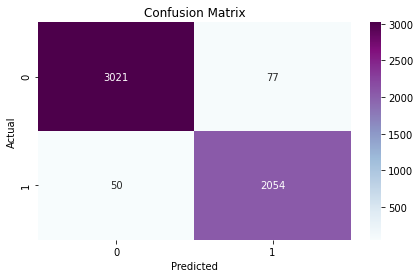

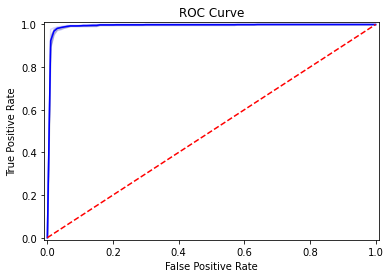

In [28]:
model = GradientBoostingClassifier
params = {'n_estimators' : n_estimators, "max_depth" : max_depth}
clf, mean_accuracy_gb, mean_precision_gb, mean_recall_gb, roc_gb, pr_gb = apply_cross_validation(model, params)

Em todos os requisitos testados (acurácia, precisão e *recall*) esse modelo resultou em uma melhor performance. Além disso, esse modelo também resultou na melhor matriz de confusão (com maiores valores na diagonal principal) e na melhor curva ROC (com maior area sob a curva). 

## Comparação Entre os Métodos

### Accuracy, Precision and Recall

Na tabela abaixo é notável que a melhor performance (em todos os 3 quesitos) foi atingido pelo **Gradient Tree Boosting**. Em contrapartida, o **k-NN** foi o modelo que atingiu o pior desempenho (também em todos os 3 quesitos).

In [29]:
data = [["Método", 'Accuracy', 'Precision', 'Recall'],
        ["Naive Bayes", mean_accuracy_nb, mean_precision_nb, mean_recall_nb],
        ["Decision Tree", mean_accuracy_dt, mean_precision_dt, mean_recall_dt],
        ["SVM (Linear)", mean_accuracy_linear_svm, mean_precision_linear_svm, mean_recall_linear_svm],
        ["SVM (Sigmoid)", mean_accuracy_sigmoid_svm, mean_precision_sigmoid_svm, mean_recall_sigmoid_svm],
        ["SVM (Poly)", mean_accuracy_poly_svm, mean_precision_poly_svm, mean_recall_poly_svm],
        ["SVM (RBF)", mean_accuracy_rbf_svm, mean_precision_rbf_svm, mean_recall_rbf_svm],
        ["k-NN", mean_accuracy_knn, mean_precision_knn, mean_recall_knn],
        ["Random Forest", mean_accuracy_rf, mean_precision_rf, mean_recall_rf],
        ["Gradient Tree Boosting", mean_accuracy_gb, mean_precision_gb, mean_recall_gb]]
table = tabulate.tabulate(data, tablefmt='grid')
print(table)

+------------------------+-----------------+-----------------+-----------------+
| Método                 | Accuracy        | Precision       | Recall          |
+------------------------+-----------------+-----------------+-----------------+
| Naive Bayes            | 0.9175+/-0.0066 | 0.8459+/-0.0132 | 0.9727+/-0.0070 |
+------------------------+-----------------+-----------------+-----------------+
| Decision Tree          | 0.9506+/-0.0045 | 0.9221+/-0.0096 | 0.9586+/-0.0067 |
+------------------------+-----------------+-----------------+-----------------+
| SVM (Linear)           | 0.9466+/-0.0039 | 0.9124+/-0.0078 | 0.9602+/-0.0048 |
+------------------------+-----------------+-----------------+-----------------+
| SVM (Sigmoid)          | 0.9239+/-0.0026 | 0.8745+/-0.0083 | 0.9478+/-0.0077 |
+------------------------+-----------------+-----------------+-----------------+
| SVM (Poly)             | 0.9475+/-0.0028 | 0.9144+/-0.0057 | 0.9601+/-0.0035 |
+------------------------+--

### ROC Curve

No gráfico abaixo nota-se que os melhores desempenhos (considerando a curva ROC) foram obtidos pelo **Gradient Tree Boosting** e pelo **Random Forest**. Em contrapartida, o k-NN foi novamente o modelo que atingiu o pior desempenho.

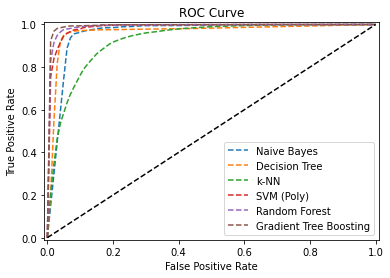

In [30]:
plt.figure(figsize=(6,4))
base_fpr = np.linspace(0, 1, 101)
# Plot mean ROC curve for all methods in the same graph
plt.plot(base_fpr, roc_nb.mean(axis=0), linestyle='--', label='Naive Bayes')
plt.plot(base_fpr, roc_dt.mean(axis=0), linestyle='--', label='Decision Tree')
plt.plot(base_fpr, roc_knn.mean(axis=0), linestyle='--', label='k-NN')
#plt.plot(base_fpr, roc_linear_svm.mean(axis=0), linestyle='--', label='SVM (Linear)')
#plt.plot(base_fpr, roc_sigmoid_svm.mean(axis=0), linestyle='--', label='SVM (Sigmoid)')
#plt.plot(base_fpr, roc_rbf_svm.mean(axis=0), linestyle='--', label='SVM (RBF)')
plt.plot(base_fpr, roc_poly_svm.mean(axis=0), linestyle='--', label='SVM (Poly)')
plt.plot(base_fpr, roc_rf.mean(axis=0), linestyle='--', label='Random Forest')
plt.plot(base_fpr, roc_gb.mean(axis=0), linestyle='--', label='Gradient Tree Boosting')
plt.plot([0, 1], [0, 1],'--k')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.legend()
plt.show()

### Precision-Recall Curve

De maneira semelhante foi também gerado um gráfico contendo as curvas *Precision-Recall* para todos os modelos. Novamente, os melhores desempenhos (considerando as curvas abaixo) foram obtidos pelo **Gradient Tree Boosting** e pelo **Random Forest**. Em contrapartida, o k-NN e o *Decision Tree* foram os modelo que atingiram o pior desempenho (menores áreas sob a curva).

A curva de precisão-recall mostra o trade-off entre precisão e *recall* para diferentes limiares. Uma área alta sob a curva representa alt *recall*  e alta precisão, onde alta precisão está relacionada a uma baixa taxa de falsos positivos e alta revocação (*recall*) está ligada a uma baixa taxa de falsos negativos.

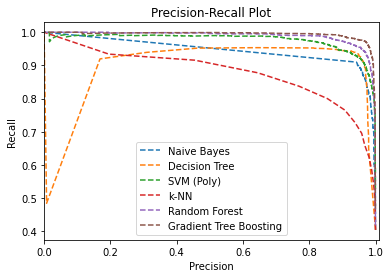

In [31]:
# Plot Precision-Recall curve for all methods in the same graph
plt.plot(pr_nb[1], pr_nb[0], linestyle='--', label='Naive Bayes')
plt.plot(pr_dt[1], pr_dt[0], linestyle='--', label='Decision Tree')
#plt.plot(pr_lsvm[1], pr_lsvm[0], linestyle='--', label='SVM (Linear)')
#plt.plot(pr_ssvm[1], pr_ssvm[0], linestyle='--', label='SVM (Sigmoid)')
#plt.plot(pr_rsvm[1], pr_rsvm[0], linestyle='--', label='SVM (RBF)')
plt.plot(pr_psvm[1], pr_psvm[0], linestyle='--', label='SVM (Poly)')
plt.plot(pr_knn[1], pr_knn[0], linestyle='--', label='k-NN')
plt.plot(pr_rf[1], pr_rf[0], linestyle='--', label='Random Forest')
plt.plot(pr_gb[1], pr_gb[0], linestyle='--', label='Gradient Tree Boosting')
plt.title('Precision-Recall Plot')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.xlim([0, 1.01])
plt.legend() 
plt.show()